# Customizability

`Spatialproteomics` provides wrappers around a variety of external tools, such as `cellpose` or `astir`. However, as technology progresses, new tools emerge. To accomodate for this, `spatialproteomics` is fully customizable, meaning that you can for example load your own segmentation masks into the object, load custom cell type annotations, etc.

If you want to follow along with this tutorial, you can download the data [here](https://oc.embl.de/index.php/s/XzEa9po1tjiDzzJ).

In [1]:
%reload_ext autoreload
%autoreload 2

import spatialproteomics
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cv2
import pandas as pd

# loading in a data set and only keeping the image
ds = xr.open_zarr("../../data/LN_24_1_unprocessed.zarr").pp.drop_layers(keep="_image")
ds

<xarray.Dataset> Size: 504MB
Dimensions:   (channels: 56, y: 3000, x: 3000)
Coordinates:
  * channels  (channels) <U11 2kB 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * x         (x) int64 24kB 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y         (y) int64 24kB 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    _image    (channels, y, x) uint8 504MB dask.array<chunksize=(7, 375, 750), meta=np.ndarray>

## Custom Segmentations

If you have a custom segmentation, you can easily add it to the object using `pp.add_segmentation()`.

In [2]:
# dummy array. Instead of this, you could run your own segmentation method here and obtain a numpy array like that
# note that this array should consist of integers, and 0 should mark the background
custom_segmentation = np.zeros((3000, 3000), dtype=int)
custom_segmentation[500:1500, 500:1500] = 1

ds = ds.pp.add_segmentation(custom_segmentation)
ds

<xarray.Dataset> Size: 576MB
Dimensions:        (channels: 56, y: 3000, x: 3000, cells: 1, features: 2)
Coordinates:
  * channels       (channels) <U11 2kB 'DAPI' 'Helios' ... 'CD79a' 'Ki-67'
  * x              (x) int64 24kB 0 1 2 3 4 5 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 24kB 0 1 2 3 4 5 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 8B 1
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint8 504MB dask.array<chunksize=(7, 375, 750), meta=np.ndarray>
    _segmentation  (y, x) int64 72MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 16B 999.5 999.5

Note that our object now contains the `_segmentation` layer. It also computed the centroids of the cells and stored them in `_obs`.

## Custom Image Processing

To apply custom image processing methods, you can make use of the `pp.apply()` method, into which you can pass any function that transforms an array. For example, let's consider one that blurs the image and subtracts it from the original.

In [3]:
def simple_background_subtraction(image, kernel_size=51):
    # ensure input is numpy array
    img = np.array(image)

    # convert dtype for OpenCV (expects uint8 or float32)
    if img.dtype != np.uint8 and img.dtype != np.float32:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # compute background with Gaussian blur
    background = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    # subtract background
    subtracted = cv2.subtract(img, background)

    # normalize result
    result = cv2.normalize(subtracted, None, 0, 255, cv2.NORM_MINMAX)

    return result


ds_processed = ds.pp.apply(func=simple_background_subtraction)

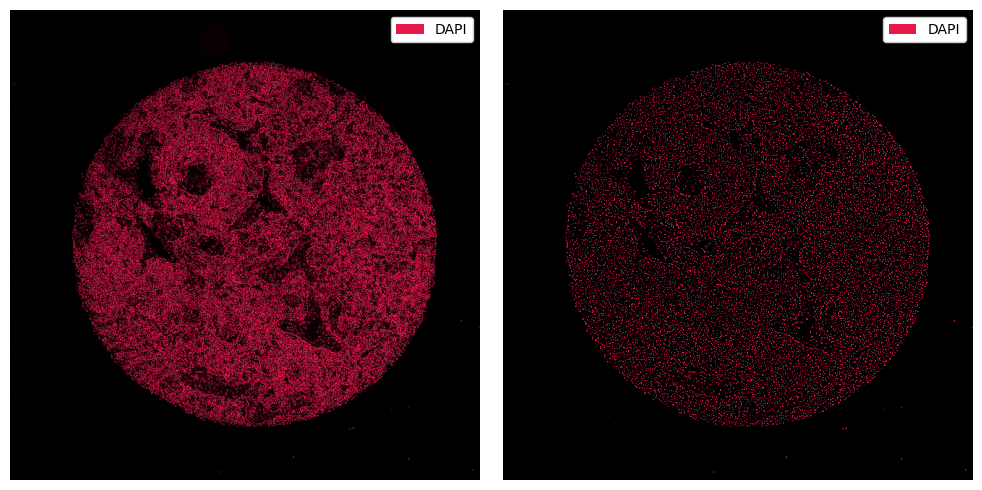

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds.pp["DAPI"].pl.show(ax=ax[0])
_ = ds_processed.pp["DAPI"].pl.show(ax=ax[1])

for axis in ax:
    axis.axis("off")
plt.tight_layout()

## Custom Protein Quantification

Typically, the mean or median intensity of each marker are aggregated per cell to obtain an expression matrix. However, this is also fully customizable. You could for example look at how spatially distributed a marker is within each cell mask. To do this, you can define a custom function that takes a segmentation mask and an image as input.

In [5]:
# loading the dataset including a proper cell segmentation
# also subsetting for easier visualization
ds = xr.open_zarr("../../data/LN_24_1_unprocessed.zarr").pp[1000:1300, 1000:1300]

In [6]:
# this is a very simple method that looks at the variance of a marker within a cell
def spatial_variance(regionmask, intensity_image):
    intensities = intensity_image[regionmask]
    return np.var(intensities)


ds = ds.pp.add_quantification(func=spatial_variance)
ds

<xarray.Dataset> Size: 6MB
Dimensions:        (channels: 56, y: 301, x: 301, cells: 416, features: 2)
Coordinates:
  * cells          (cells) int64 3kB 4304 4311 4312 4318 ... 7269 7270 7271 7306
  * channels       (channels) <U11 2kB 'DAPI' 'Helios' ... 'CD79a' 'Ki-67'
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
  * x              (x) int64 2kB 1000 1001 1002 1003 ... 1297 1298 1299 1300
  * y              (y) int64 2kB 1000 1001 1002 1003 ... 1297 1298 1299 1300
Data variables:
    _image         (channels, y, x) uint8 5MB dask.array<chunksize=(7, 125, 301), meta=np.ndarray>
    _obs           (cells, features) float64 7kB dask.array<chunksize=(416, 2), meta=np.ndarray>
    _segmentation  (y, x) int64 725kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    _intensity     (cells, channels) float64 186kB 265.9 0.0 ... 7.35 0.2526

Note that the computed values are now stored in the `_intensity` layer. For a quick visualization, we can put them into `_obs`. We do this by using `pp.add_feature()`.

In [7]:
dapi_variance = ds.pp.get_layer_as_df("_intensity")["DAPI"].values
ds = ds.pp.add_feature(feature_name="dapi_variance", feature_values=dapi_variance)

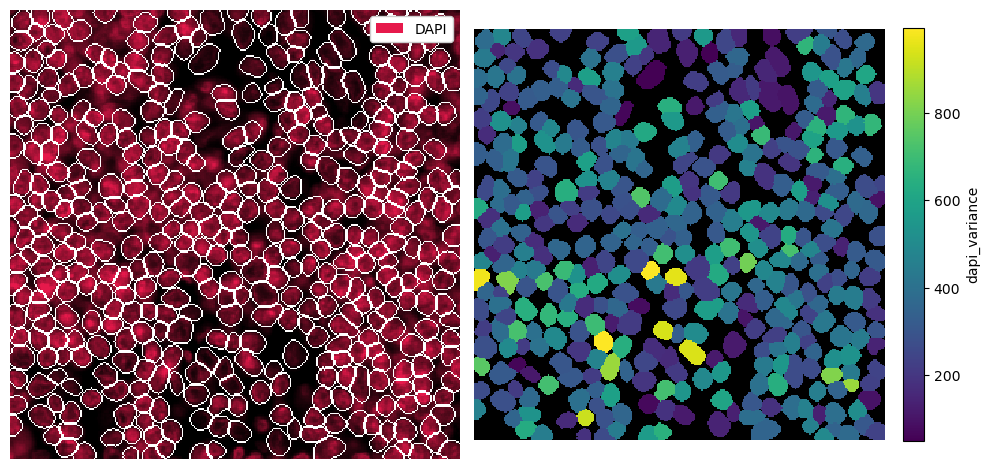

In [8]:
# visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds.pp["DAPI"].pl.show(render_segmentation=True, ax=ax[0])
_ = ds.pl.render_obs("dapi_variance").pl.imshow(legend_obs=True, ax=ax[1])

for axis in ax:
    axis.axis("off")
plt.tight_layout()

## Custom Cell Type Prediction

If you have custom labels per cell, you can easily load them into the `spatialproteomics` object with the `la.add_labels_from_dataframe()` method. The input dataframe simply needs a column identifying the cells and one identifying the labels.

In [9]:
num_cells = ds.sizes["cells"]
cell_ids = ds["cells"].values

# define some example cell types and randomly assign them
# substitute this with your cell type prediction method of choice
cell_types = ["B cell", "T cell", "Macrophage"]
cell_labels = np.random.choice(cell_types, size=num_cells, replace=True)

label_df = pd.DataFrame({"cell": cell_ids, "label": cell_labels})
label_df.head()

,cell,label
0,4304,T cell
1,4311,Macrophage
2,4312,Macrophage
3,4318,Macrophage
4,4327,B cell


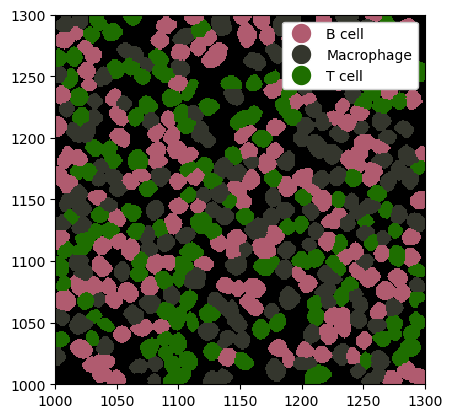

In [10]:
# adding the labels to the spatialproteomics object
ds = ds.la.add_labels_from_dataframe(label_df)

# visualization
_ = ds.pl.show(render_image=False, render_labels=True)